In [1]:
import argparse
import os
import numpy as np
import torch as th
from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
    add_dict_to_argparser,
)
from tqdm import tqdm
from IPython.display import Image, display
from guided_diffusion.image_datasets import load_data

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torchvision import utils
from resizer import Resizer
import math

# Load model

In [2]:
sample_dict = dict(clip_denoised=True, alpha=1.0, num_steps=1000,
                   batch_size=1, down_N=32, range_t=20,
                   use_ddim=False, base_samples="./ref_imgs/face",
                   model_path="./models/ffhq_10m.pt", 
                   save_dir="./output", save_latents=False)

defaults = model_and_diffusion_defaults()
model, diffusion = create_model_and_diffusion(**defaults)
model.load_state_dict(dist_util.load_state_dict(sample_dict['model_path'], map_location="cpu"))
model = model.to(dist_util.dev())
model = model.eval()
print(diffusion.num_timesteps)
print(diffusion.model_mean_type, diffusion.model_var_type)

1000
ModelMeanType.EPSILON ModelVarType.LEARNED_RANGE


# Setup dataloader

In [3]:
def load_reference(data_dir, batch_size, image_size, class_cond=False):
    data = load_data(
        data_dir=data_dir,
        batch_size=batch_size,
        image_size=image_size,
        class_cond=class_cond,
        deterministic=True,
        random_flip=False,
    )
    for large_batch, model_kwargs in data:
        model_kwargs["ref_img"] = large_batch
        yield model_kwargs

data = load_reference(sample_dict['base_samples'],
                      sample_dict['batch_size'],
                      image_size=defaults['image_size'],
                      class_cond=defaults['class_cond'])

In [13]:
def define_mask(ipt_image, x_cor=100, y_cor=100, height=100, width=100):
    mask = th.ones(ipt_image.shape).cuda()
    mask[:, x_cor:x_cor+width, y_cor:y_cor+height] = 0.0
    return mask
    
def reconstruct_mcg(diffusion_model, diffusion_process, y_inpainted, mask, var_dict, tau=1.0):
    
    l = []
    indices = list(range(var_dict['num_steps']))[::-1]
    xt = th.randn(y_inpainted.shape, dtype=y_inpainted.dtype, 
                  device=y_inpainted.device,
                  requires_grad=True)/np.sqrt(tau)
    B, C = xt.shape[:2]
    for i in tqdm(indices):
        t = th.tensor([i], device=xt.device)
        
        with th.no_grad():
            
            rho = diffusion_process.sqrt_alphas_cumprod[t]
            labda = diffusion_process.sqrt_one_minus_alphas_cumprod[t]

            with th.enable_grad():
                # inpainting algorithm
                xt = xt.requires_grad_(True)
                sample_dict = diffusion_process.p_mean_variance(diffusion_model, xt, t)

                x0_hat =  sample_dict['pred_xstart']
                x0_hat_inpainted = mask * x0_hat
                
                mcg = ((y_inpainted - x0_hat_inpainted)).pow(2).mean()#.sum()/256/256*100*100
                g = th.autograd.grad(mcg, xt)[0]
            
            l.append(th.norm(g).item())
            xt_mean, xt_logvar = sample_dict['mean'], sample_dict['log_variance']
            epi_x = th.randn(xt.shape, dtype=xt.dtype, 
                             device=xt.device,
                             requires_grad=False)/np.sqrt(tau)
            xt_1_ = xt_mean + epi_x * th.exp(0.5 * xt_logvar)
            xt_1__ = xt_1_ - var_dict['alpha']*g
            
            epi_y = th.randn(xt.shape, dtype=xt.dtype, 
                             device=xt.device,
                             requires_grad=False)
            y_t = rho * y_inpainted + labda * epi_y
            xt = (1 - mask) * xt_1__ + mask * y_t
    return xt, l

def reconstruct_vanilla(diffusion_model, diffusion_process, 
                        y_inpainted, mask, var_dict, tau=1.0):
    
    indices = list(range(var_dict['num_steps']))[::-1]
    xt = th.randn(y_inpainted.shape, dtype=y_inpainted.dtype, 
                  device=y_inpainted.device,
                  requires_grad=True)/np.sqrt(tau)
    B, C = xt.shape[:2]
    for i in tqdm(indices):
        t = th.tensor([i], device=xt.device)
        
        with th.no_grad():
            
            rho = diffusion_process.sqrt_alphas_cumprod[t] * y_inpainted
            labda = diffusion_process.sqrt_one_minus_alphas_cumprod[t]
            epi = th.randn(xt.shape, dtype=xt.dtype, 
                           device=xt.device,
                           requires_grad=False)
            xt_hat = rho + epi * labda
            xt = xt_hat*mask + xt * (1-mask)
            
            sample_dict = diffusion_process.p_mean_variance(diffusion_model, xt, t)
            xt_mean, xt_logvar = sample_dict['mean'], sample_dict['log_variance']
            epi_x = th.randn(xt.shape, dtype=xt.dtype, 
                             device=xt.device,
                             requires_grad=False)/np.sqrt(tau)
            xt_1 = xt_mean + epi_x * th.exp(0.5 * xt_logvar)
            xt = (1 - mask) * xt_1 + mask * y_inpainted
    return xt


100%|██████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


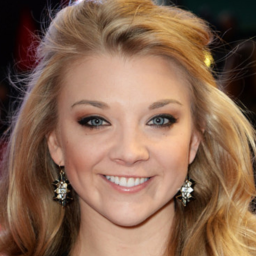

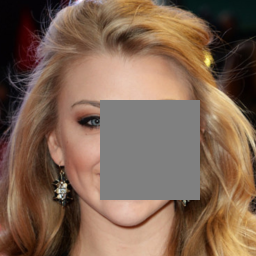

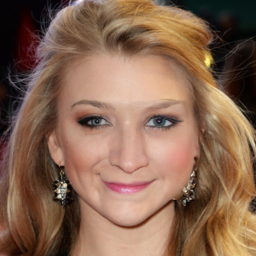

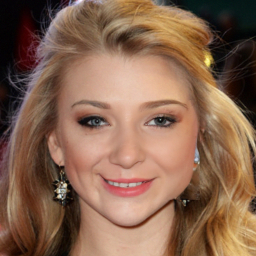

In [14]:
def save_and_display(save_path, image_data, image_type='original'):
    
    outpath = os.path.join(save_path, image_type + '.png')
    utils.save_image(image_data, outpath, nrow=1, 
                     normalize=True, range=(-1, 1))
    display(Image(filename=outpath))
    
while True:
    model_kwargs = next(data)
    model_kwargs = {k: v.to(dist_util.dev()) for k, v in model_kwargs.items()}
    
    image_ori = model_kwargs['ref_img'][0]
    mask = define_mask(image_ori)
    image_inp = (mask * image_ori).unsqueeze(0)
    
    image_recon_v1 = reconstruct_vanilla(model, diffusion, image_inp, mask, sample_dict)
    image_recon_v2, l = reconstruct_mcg(model, diffusion, image_inp, mask, sample_dict)
    
    save_and_display(sample_dict['save_dir'], image_ori)
    save_and_display(sample_dict['save_dir'], image_inp, 'inpainted')
    save_and_display(sample_dict['save_dir'], image_recon_v1, 'recon_v1')
    save_and_display(sample_dict['save_dir'], image_recon_v2, 'recon_v2')
    break

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.plot(l)
print(l[-1])